# 0X_tree_models



In [1]:
import os
import math
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import statsmodels.formula.api as sm

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
import logging

# Improve resolution of output graphcis
%matplotlib inline
%config InlineBackend.figure_format ='retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

In [2]:
import sys
sys.path.append('..')

In [3]:
# !pip install graphviz
# !brew install graphviz
from sklearn import tree
import graphviz

In [4]:
from src.scale import *
from src.model import *
from src.datagen import generate_interval_data

## Get Project Data Based on Interval

In [5]:
file_path = '../data/interim/Capital_Projects_clean.csv'
    
if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [6]:
data = pd.read_csv(file_path)

In [7]:
data = pd.read_csv(file_path)
data = generate_interval_data(data, change_year_interval=3)

The number of unique projects in the resulting dataframe: 149



## Select Attributes (X) and Target Values (Y)

In [8]:
# All possible (reasonable) Attributes
X_cols_all = [
    'Category',
    'Borough',
    'Managing_Agency',
    'Client_Agency',
    'Budget_Start',
    'Duration_Start'
]

# includes +/- values of total change
y_cols_change = [
    'Budget_Change',
    'Schedule_Change'
]

# final budget amount and duration
y_cols_end_value = [
    'Budget_End',
    'Duration_End'
]

# includes +/- values of relative change
y_cols_ratio = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]


### Define the X and Y Columns

In [9]:
def dummify(df, x_cols, col_names) -> (pd.DataFrame, list):
    
    dummy_cols_dict = {}
    
    for col_name in col_names:
        
        start_cols = df.columns
        df = encode_categories(df, col_name, one_hot=True, drop_cat=None, cat_list=None, drop_original_col=True)

        # get column differences of before and after making dummies
        new_dummy_cols = list(set(df.columns) - set(start_cols))

        # remove the original and replace with one-hot encoded columns
        x_cols.remove(col_name)
        x_cols += new_dummy_cols
        
        # keep a dictionary of changes
        dummy_cols_dict.update({col_name: new_dummy_cols})

    return df, x_cols, dummy_cols_dict

In [10]:
def define_train_and_test(data, dummy_cols, attributes, responses): 
    
    X_cols = attributes.copy() #X_cols_all.copy()

    # define the y column set to use
    y_cols = responses.copy()

    # dummify selected columns
    data_dummies, X_cols, dummies_dict = dummify(data, X_cols, dummy_cols)

    # define the starting X and y datasets
    X, y = data_dummies[X_cols], data_dummies[y_cols]

    # make the y values categorical
    y = (y>0)*1

    # create train and test sets
    random_state = 109
    test_size = 0.1

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        shuffle=True)
    
    return X_tr, X_te, y_tr, y_te, dummies_dict

In [11]:
# define the x colum set to use
attributes = [  'Category',
                'Borough',
                'Managing_Agency',
                'Client_Agency',
                'Budget_Start',
                'Duration_Start' ]

dummy_columns = ['Category', 'Borough', 'Managing_Agency', 'Client_Agency']

responses = [ 'Budget_Change',
              'Schedule_Change' ]

X_train, X_test, y_train, y_test, dummies_dict = define_train_and_test(data, dummy_columns, attributes, responses)


In [12]:
# double check sizes
print('{}\t{}'.format(X_train.shape, y_train.shape))
print('{}\t{}'.format(X_test.shape, y_test.shape))

(134, 54)	(134, 2)
(15, 54)	(15, 2)


In [13]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify columns to exclude from scaling (i.e. binary and non-predictor columns)
exclude_scale_cols = dummy_columns

# Perform standard scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None

X_train_stdz, Scaler_stdz = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_stdz, Scaler_stdz = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

# Perform standard scaling and then pass through sigmoid transformation
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid

X_train_stdz_sig, _ = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_stdz_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)


# Perform normalized scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = MinMaxScaler
scale_before_func = None
scale_after_func = None

X_train_norm, Scaler_norm = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_norm, Scaler_norm = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)


# Perform normalized scaling then add 1 and perform log transformation and renormalize
scaler = MinMaxScaler
scale_before_func = None
scale_after_func = log_plus_one
reapply_scaler = True

X_train_norm_log, _ = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_norm_log, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Perform 'Robust' scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = RobustScaler
scale_before_func = None
scale_after_func = None

X_train_rob, Scaler_rob = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_rob, Scaler_rob = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)



In [14]:
float in (pd.core.series.Series, pd.core.frame.DataFrame)

False

In [15]:
type(y_train) in (pd.core.series.Series, pd.core.frame.DataFrame)

True

In [16]:
type(y_train[responses]) in (pd.core.series.Series, pd.core.frame.DataFrame)

True

## Define functions for fitting and evaluating models

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline # added
from sklearn.model_selection import cross_validate # added

In [18]:
# Decision Tree 

depths = list(range(1, 21))
cv = 5

def calc_meanstd(X_tr, y_tr, X_te, y_te, depths:list=depths, cv:int=cv):
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    test_scores = []
    models = []
    
    for d in depths:
        # make a pipeline object with model
        model = DecisionTreeClassifier(max_depth=d, random_state=0)
#         dt_pipeline = make_pipeline(DecisionTreeClassifier(max_depth=d, random_state=0))
        model.fit(X_tr, y_tr) # train model
        
        # cross validation
        cvmeans.append(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, n_jobs=-1)))
        cvstds.append( np.std (cross_val_score(model, X_te, y_te, cv=cv, n_jobs=-1)))
    
        train_scores.append( model.score(X_tr, y_tr) )  # append mean of cv train scores
        test_scores.append(  model.score(X_te, y_te)  ) # append mean of cv test scores
        models.append(model)

    # make the lists np.arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)

    
    # end of your code here
    return cvmeans, cvstds, train_scores, test_scores, models

In [19]:
# Plot tree
def plot_tree(data, dummy_cols:list, attributes:list, responses_list:list):
    
    results = []
    fig, ax = plt.subplots(ncols = 3, figsize=(15,6))
    
    for i, responses in enumerate(responses_list):
    
        if type(responses) == str:
            responses = [responses]

        X_tr, X_te, y_tr, y_te, dummies_dict = define_train_and_test(data, dummy_cols, attributes, responses)
        cvmeans, cvstds, train_scores, test_scores, models = calc_meanstd(X_tr, 
                                                                          y_tr[responses], 
                                                                          X_te, 
                                                                          y_te[responses])
        best_model = models[cvmeans.argmax()]
        title = f"Response: {responses} \n Attributes: {attributes}"

        x = np.array(depths)
        y = cvmeans

        ax[i].fill_between(x, y + 2*cvstds, y - 2*cvstds, alpha=0.2)

        #Plot
        ax[i].set_xlabel("Maximum Tree Depth")
        best_cv_score = np.round(cvmeans.max(),2)
        best_depth = cvmeans.argmax()+1
        ax[i].set_title(f"{title}\nBest cv-test score: {best_cv_score} at depth {best_depth}", fontsize=10)
        ax[i].set_ylabel("Score")
        ax[i].set_xticks(depths)

        # Plot Cross-Validation Scores
        ax[i].plot(x, y, 'g-', marker='x', label="Mean Cross-Validation Score")

        # Plot model scores
        ax[i].plot(x, train_scores, 'b-', marker='o', label="Model Train Score")
        
        if i == 2:
            ax[i].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

        results.append({'attributes':attributes,
                        'responses':responses,
                        'best_cv_score':best_cv_score,
                        'best_depth':best_depth,
                        'best_model':best_model,
                        'dummies_dict':dummies_dict})

    
    return best_cv_score, best_depth, results

### Fit and evaluate Decision Tree Models based on various attribute and response variable combinations

In [20]:
results_all = []

/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_spl

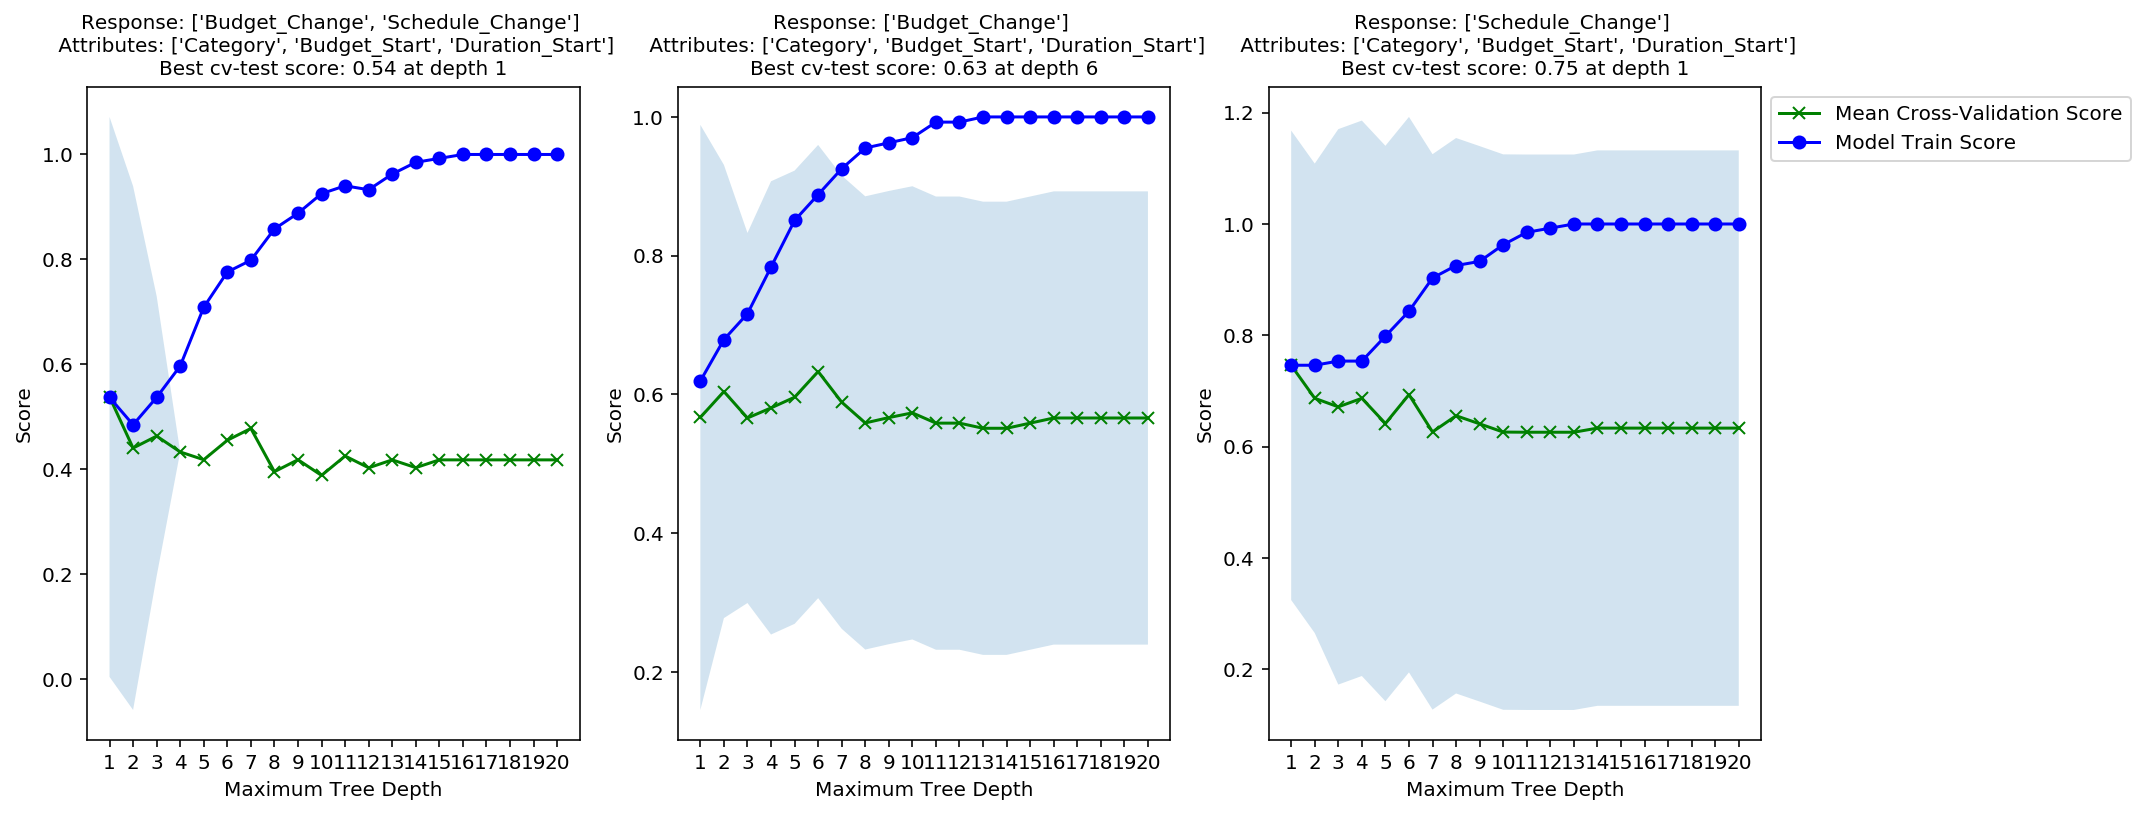

In [21]:
attributes = [  
                    'Category',
                    'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list)
results_all += results


/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_spl

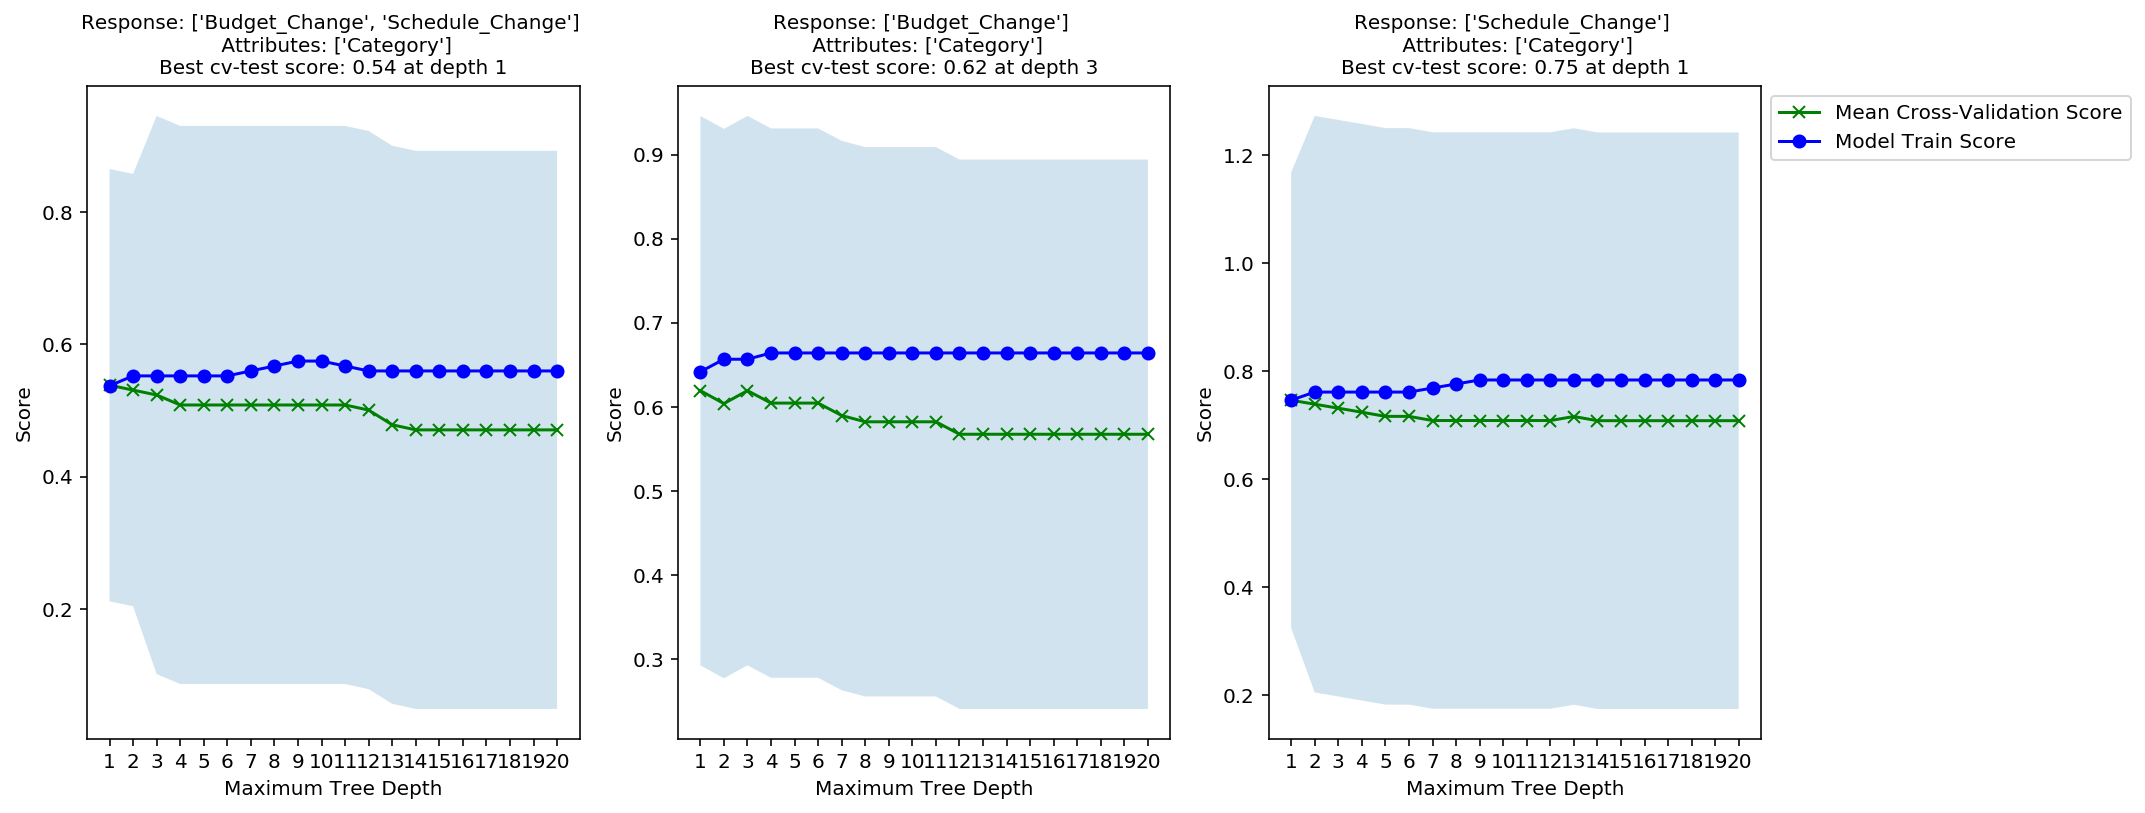

In [22]:
attributes = [  
                    'Category',
#                     'Budget_Start',
#                     'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list)
results_all += results


/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_spl

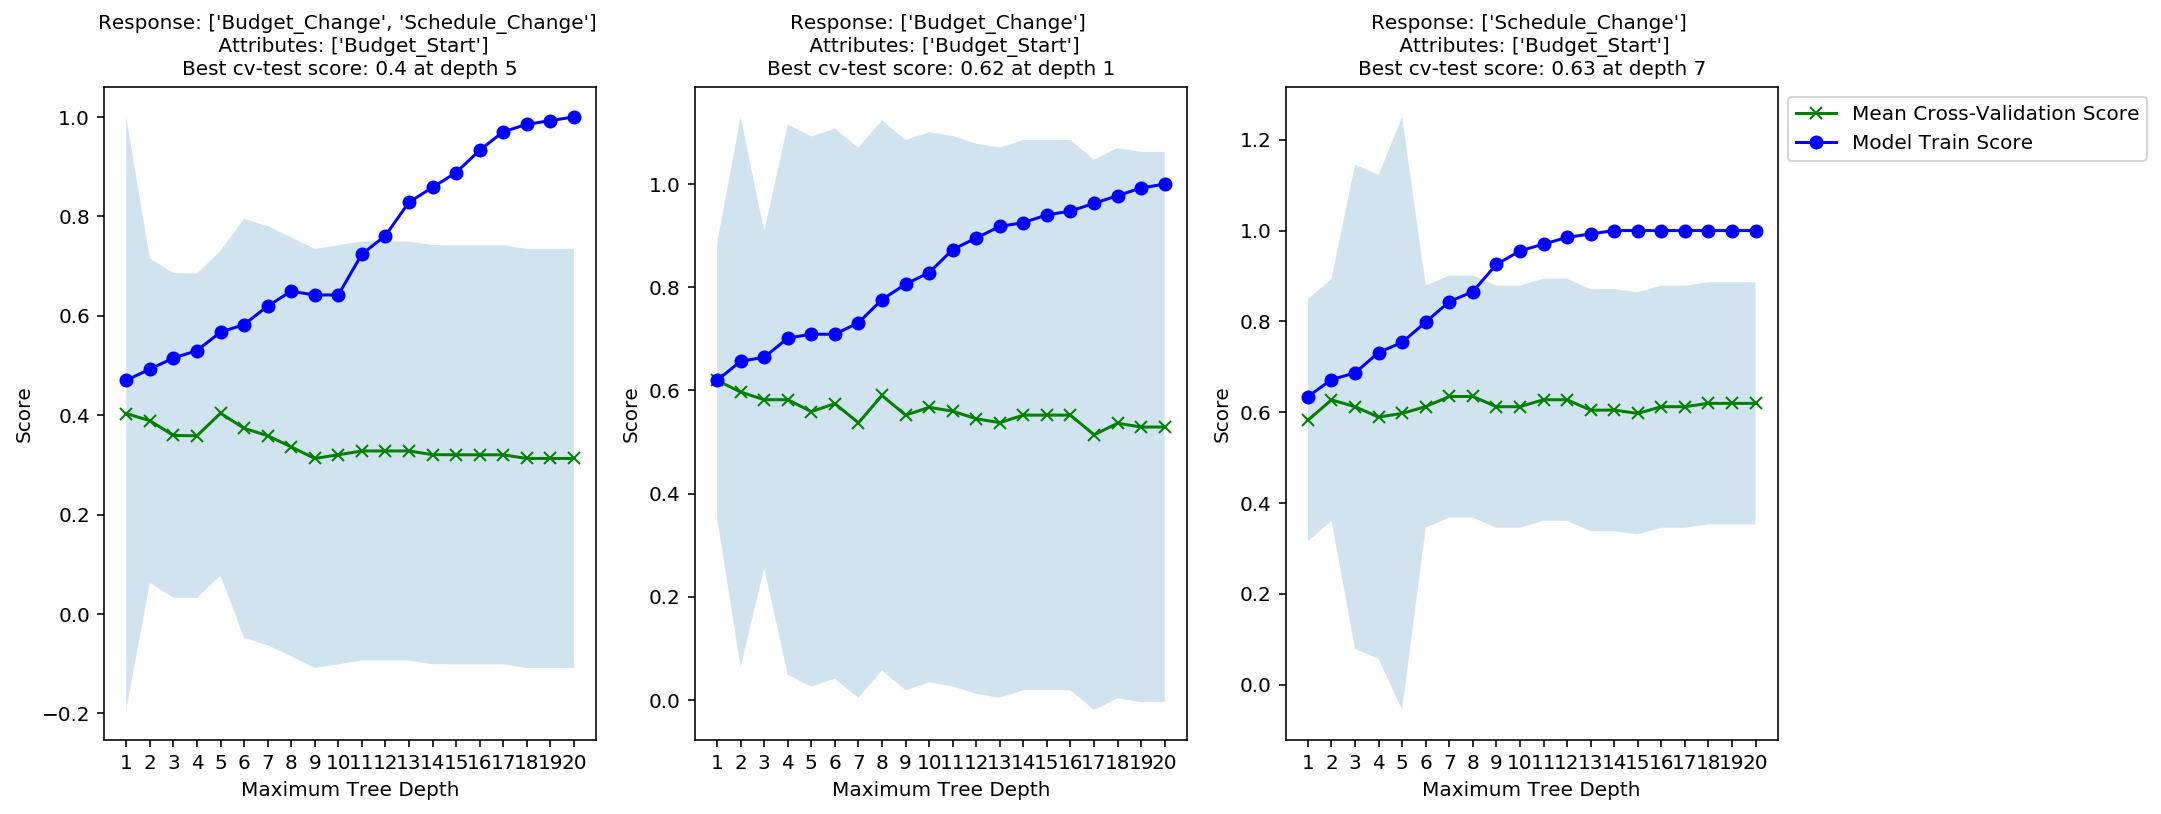

In [23]:
attributes = [  
#                     'Category',
                    'Budget_Start',
#                     'Duration_Start' 
             ]

dummy_columns = [
#                     'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list)
results_all += results


/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_spl

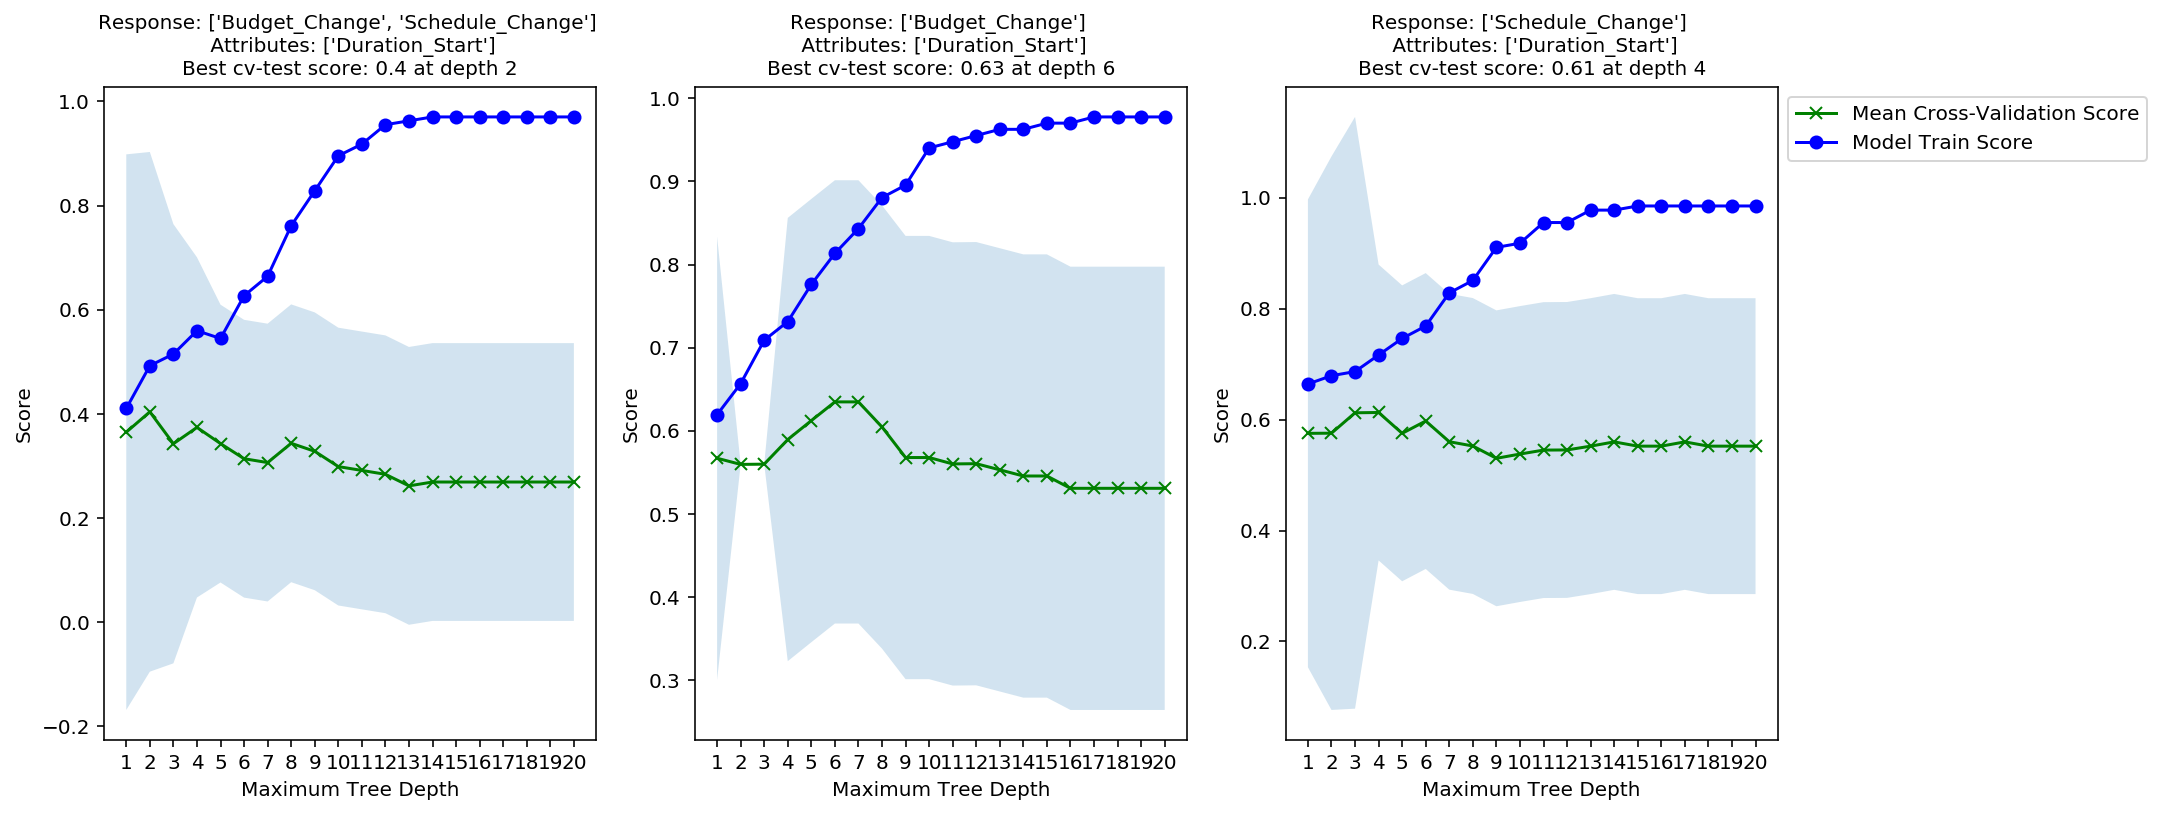

In [24]:
attributes = [  
#                     'Category',
#                     'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
#                     'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list)
results_all += results


/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_spl

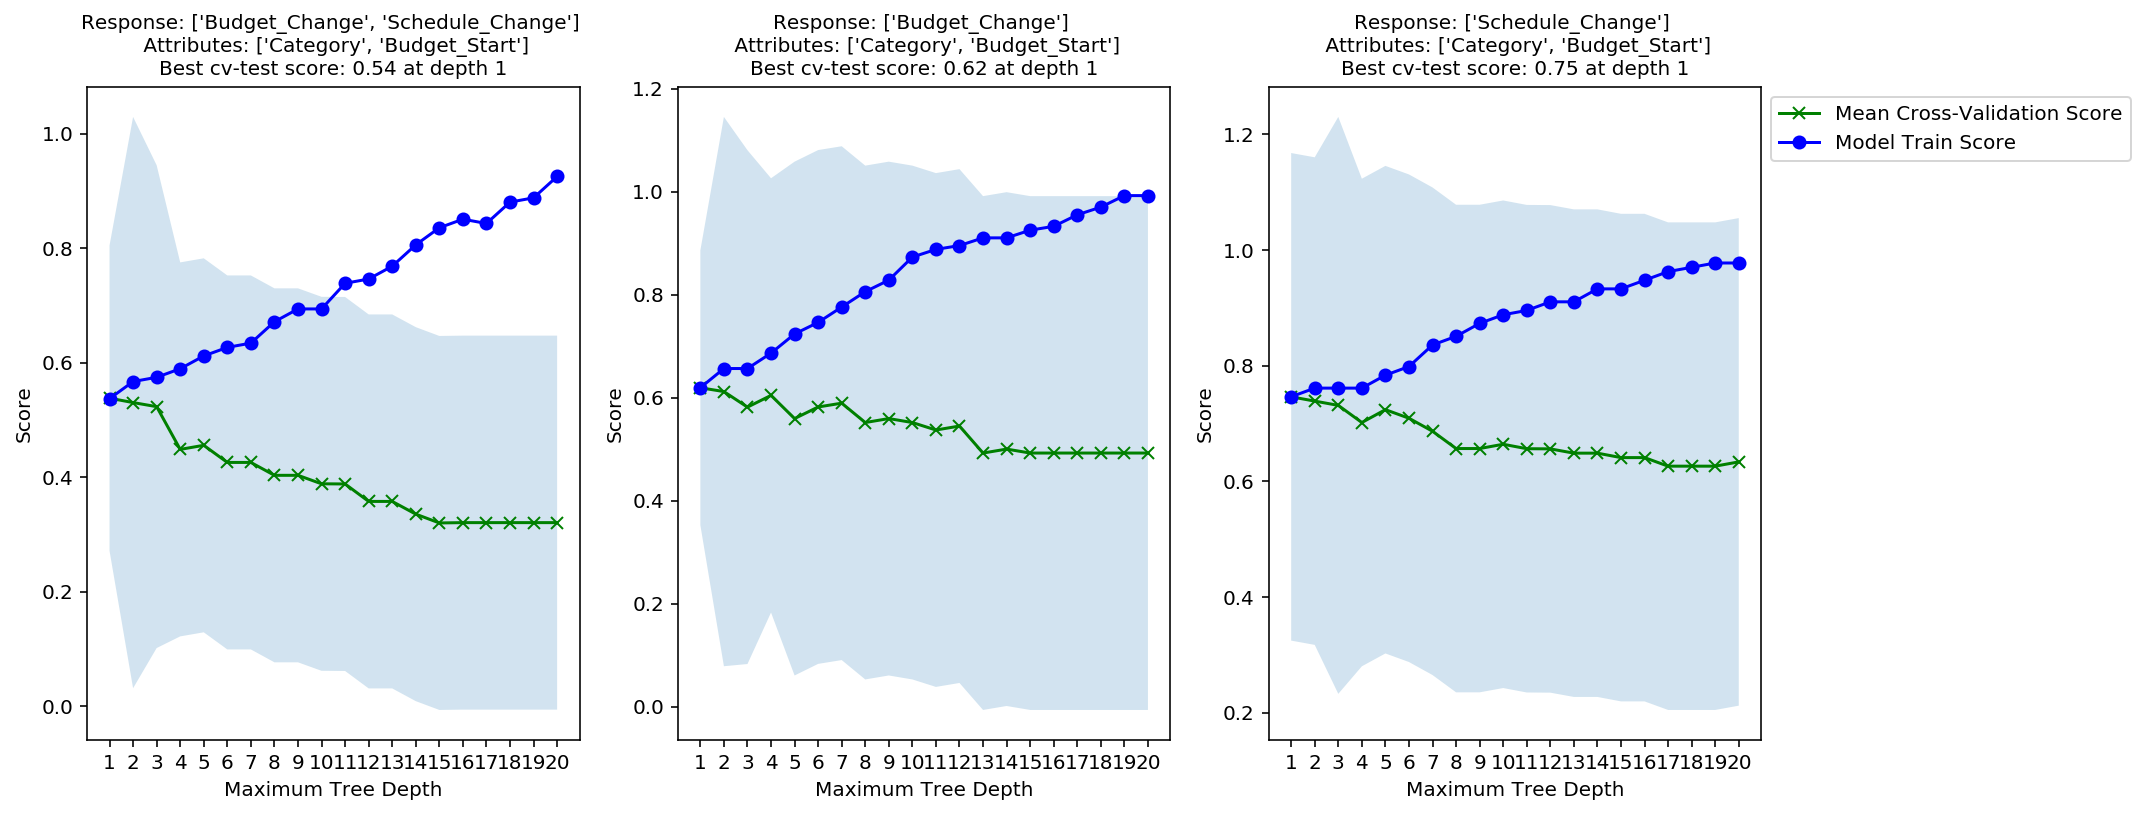

In [25]:
attributes = [  
                    'Category',
                    'Budget_Start',
#                     'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list)
results_all += results


/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_spl

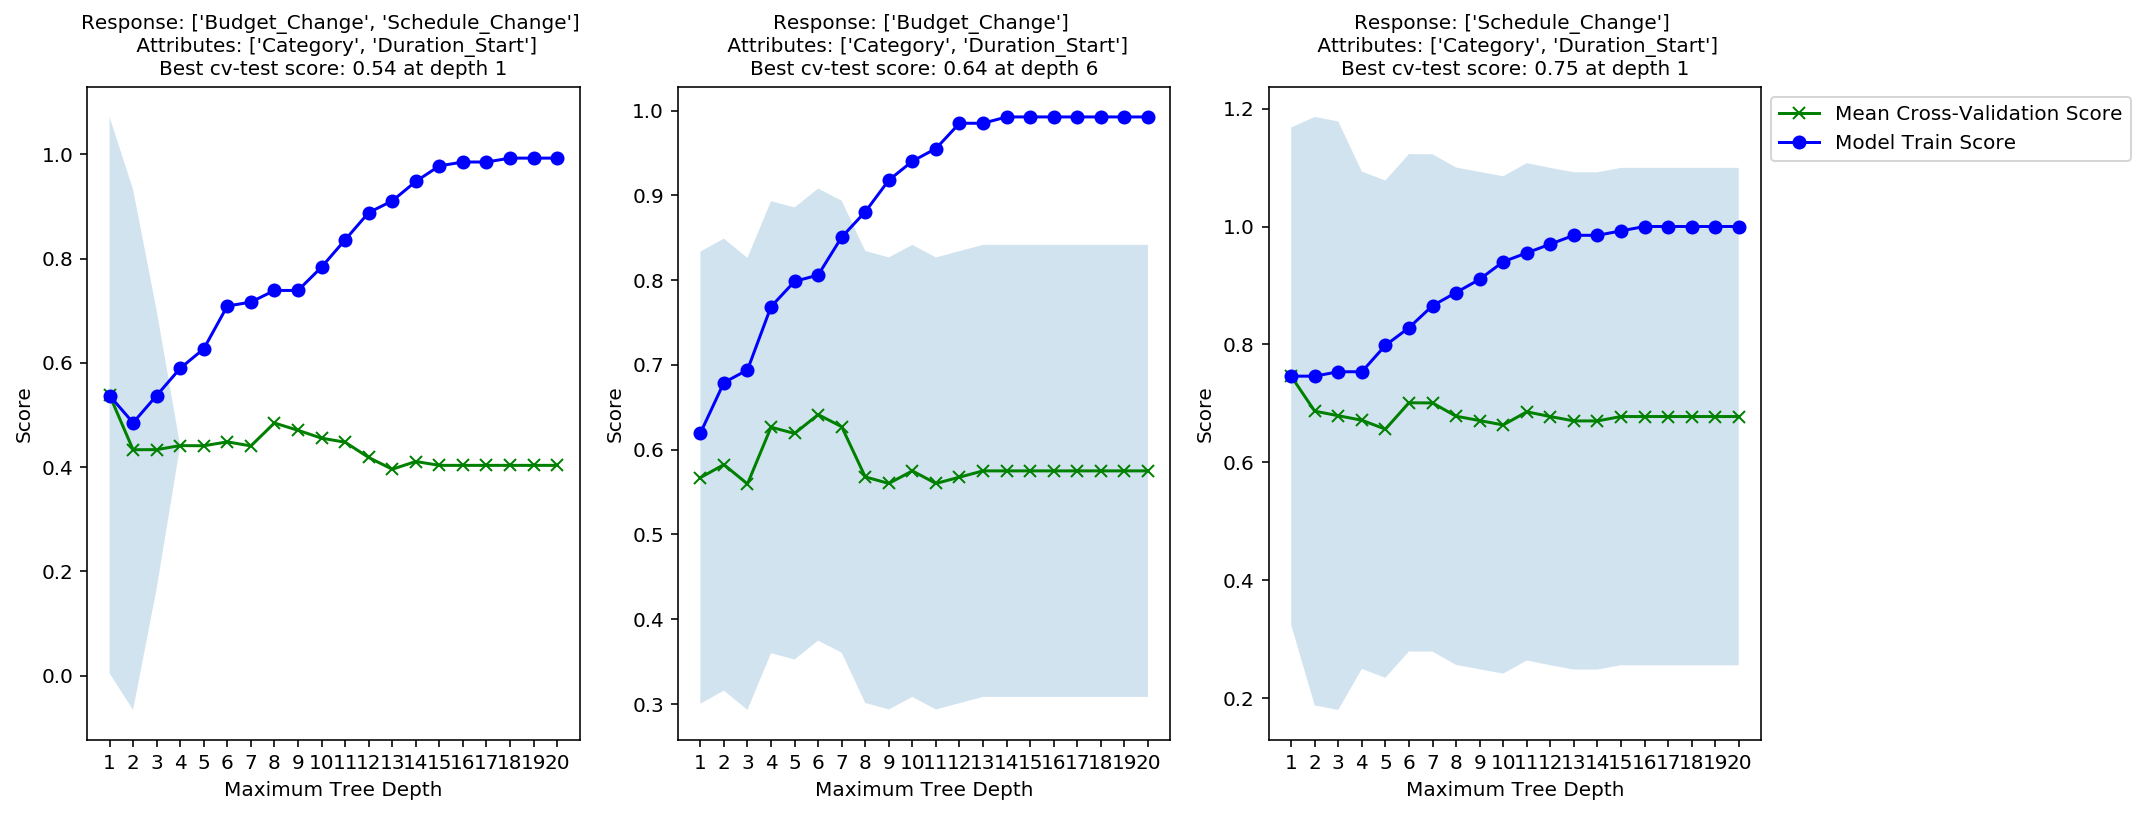

In [26]:
attributes = [  
                    'Category',
#                     'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list)
results_all += results


/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_spl

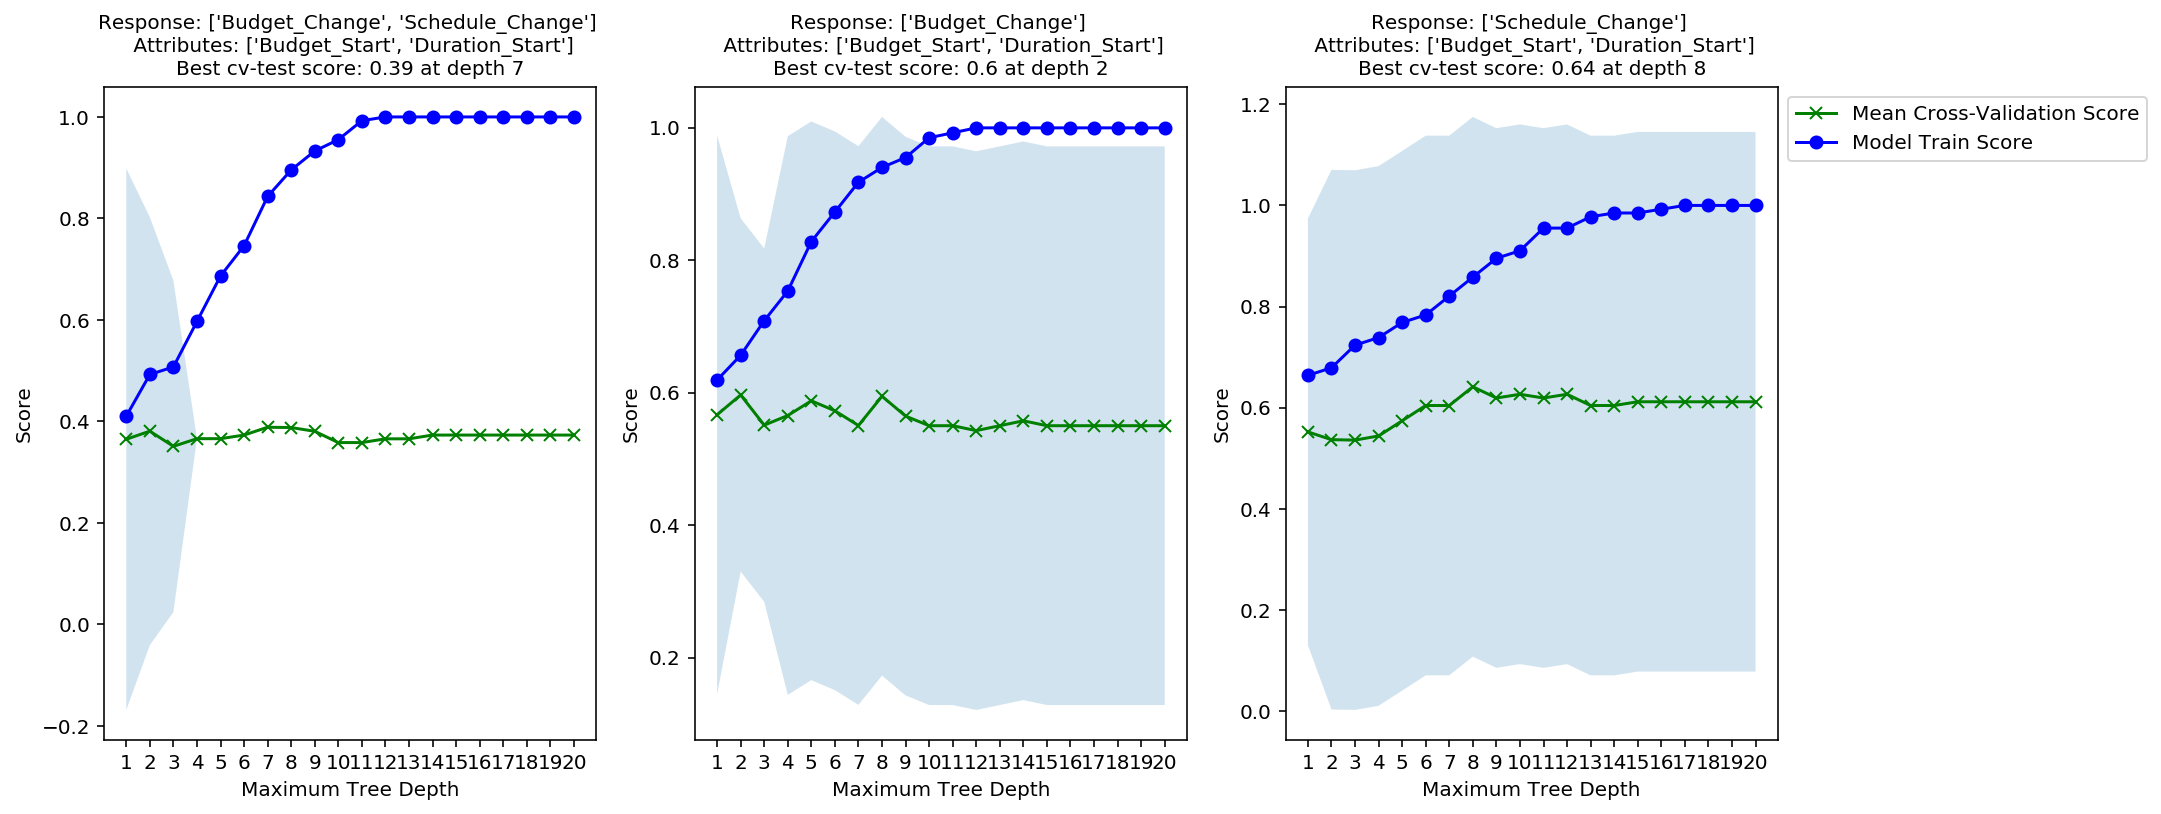

In [27]:
attributes = [  
#                     'Category',
                    'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
#                     'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list)
results_all += results


/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/markmcdonald/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_spl

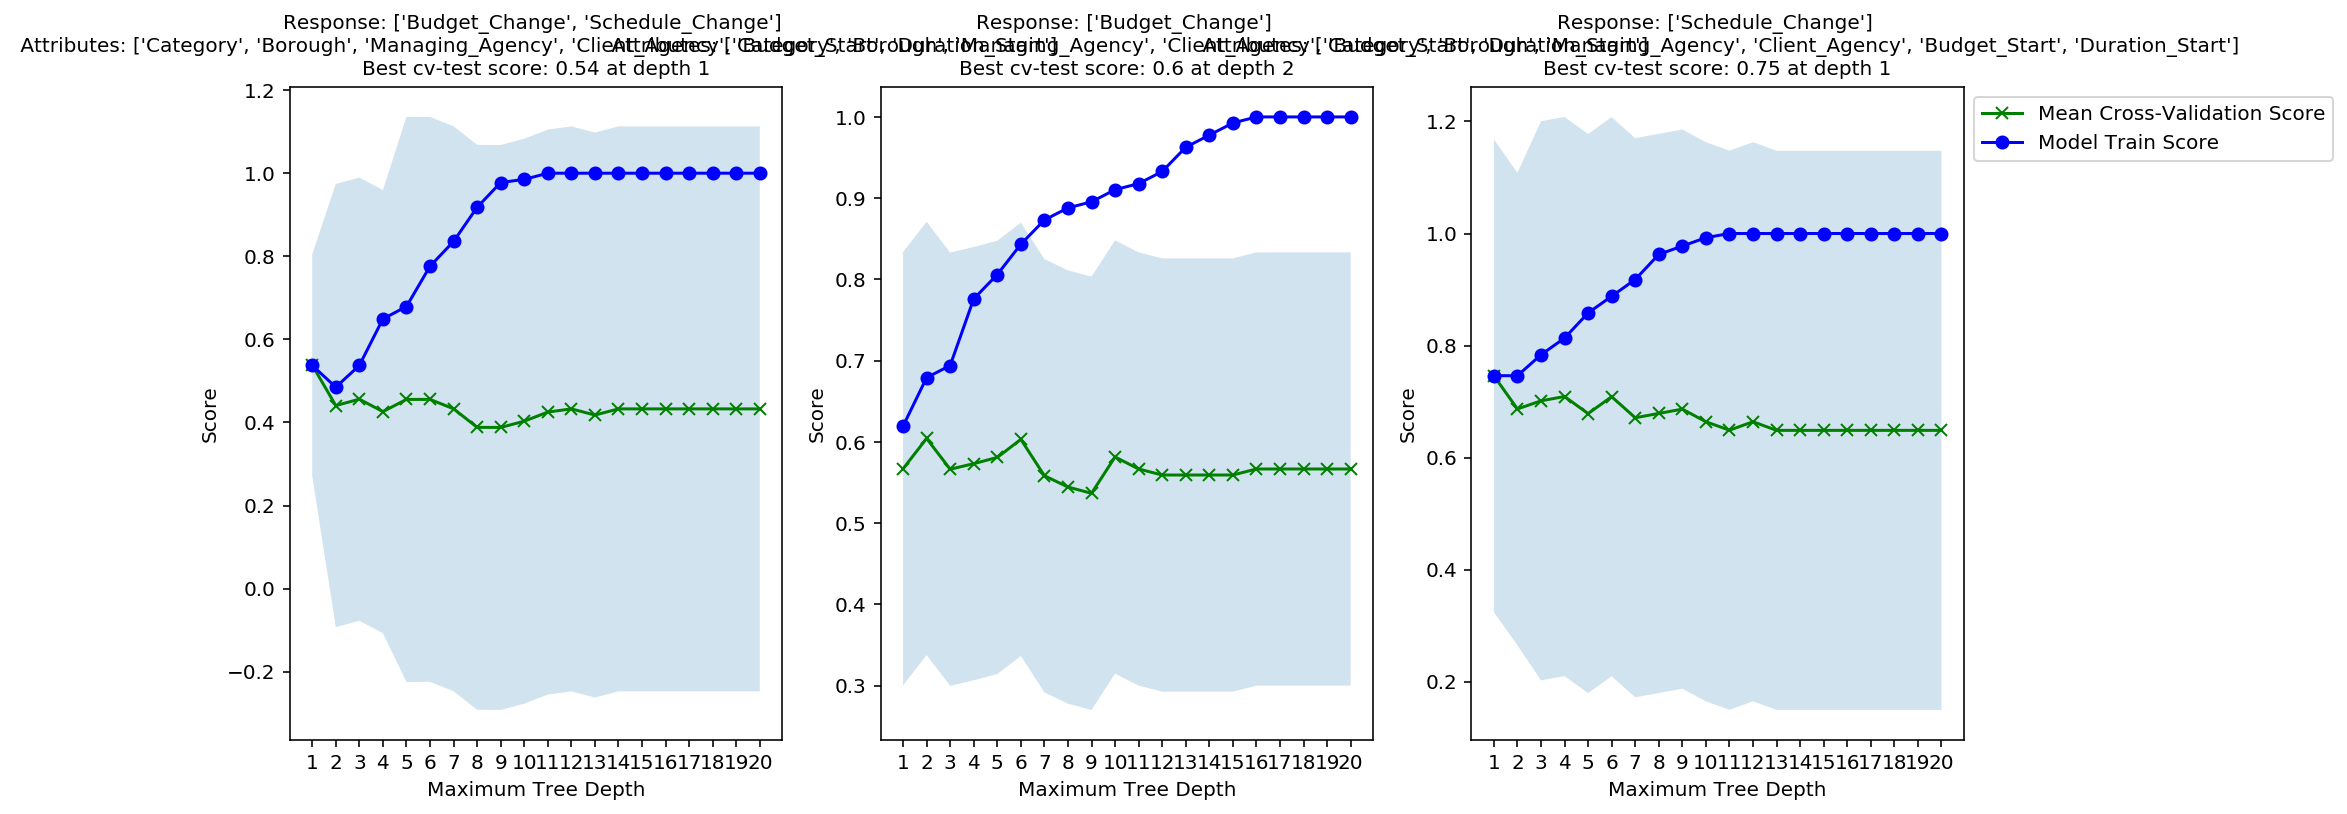

In [28]:
attributes = [  'Category',
                'Borough',
                'Managing_Agency',
                'Client_Agency',
                'Budget_Start',
                'Duration_Start' ]

dummy_columns = ['Category', 'Borough', 'Managing_Agency', 'Client_Agency']

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list)
results_all += results


In [29]:
results_df = pd.DataFrame(results_all)
results_df[results_df['best_depth'] == 1]

,attributes,responses,best_cv_score,best_depth,best_model,dummies_dict
0,"[Category, Budget_Start, Duration_Start]","[Budget_Change, Schedule_Change]",0.54,1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."
2,"[Category, Budget_Start, Duration_Start]",[Schedule_Change],0.75,1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."
3,[Category],"[Budget_Change, Schedule_Change]",0.54,1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."
5,[Category],[Schedule_Change],0.75,1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."
7,[Budget_Start],[Budget_Change],0.62,1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",{}
12,"[Category, Budget_Start]","[Budget_Change, Schedule_Change]",0.54,1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."
13,"[Category, Budget_Start]",[Budget_Change],0.62,1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."
14,"[Category, Budget_Start]",[Schedule_Change],0.75,1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."
15,"[Category, Duration_Start]","[Budget_Change, Schedule_Change]",0.54,1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."
17,"[Category, Duration_Start]",[Schedule_Change],0.75,1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."


In [30]:
results_df[results_df['best_depth'] != 1]

,attributes,responses,best_cv_score,best_depth,best_model,dummies_dict
1,"[Category, Budget_Start, Duration_Start]",[Budget_Change],0.63,6,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."
4,[Category],[Budget_Change],0.62,3,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."
6,[Budget_Start],"[Budget_Change, Schedule_Change]",0.40,5,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",{}
8,[Budget_Start],[Schedule_Change],0.63,7,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",{}
9,[Duration_Start],"[Budget_Change, Schedule_Change]",0.40,2,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",{}
10,[Duration_Start],[Budget_Change],0.63,6,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",{}
11,[Duration_Start],[Schedule_Change],0.61,4,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",{}
16,"[Category, Duration_Start]",[Budget_Change],0.64,6,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'Category': ['Parks,_Streets_and_Roadways', '..."
18,"[Budget_Start, Duration_Start]","[Budget_Change, Schedule_Change]",0.39,7,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",{}
19,"[Budget_Start, Duration_Start]",[Budget_Change],0.60,2,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",{}


### This is not conclusive, but there is some correlation
The tree is trained on all combinations of the input attributes and responses.

Most results report the best depth of 1, indicating a single attribute is used to determine the response.  These are not very insightful models and are not considered valid.  Models with depths > 1 are considered for subsequent evaluation.

### Observations
Using the models that generated their best score at a depth > 1, we can make some observations that will help us look further.  Looking at the 2 best scoring models:

- Using only the category as a model attribute, we can predict schedule changes with a reasonable amount of accuracy. This indicates that there is a category of project that has a predictable outome on the schedule.
- Combining the Budget Start value with the category as attributes creates a model that predicts schedule changes reasonably well.

Addional Observation:
- Perhaps not initially evident is the model which uses Duration Start as an attribute and predicts both responses.  This model scores .44 indicating that from just he Duration start value alone, we can predict the budget and schedule changes with .44 accuracy.  For 2 responses, guessing yields a .25 score, so the .44 is significant.


## Analyze the deepest tree

Index Chosen: 20
Best CV Score of Model Chosen: 0.64 // Depth: 8


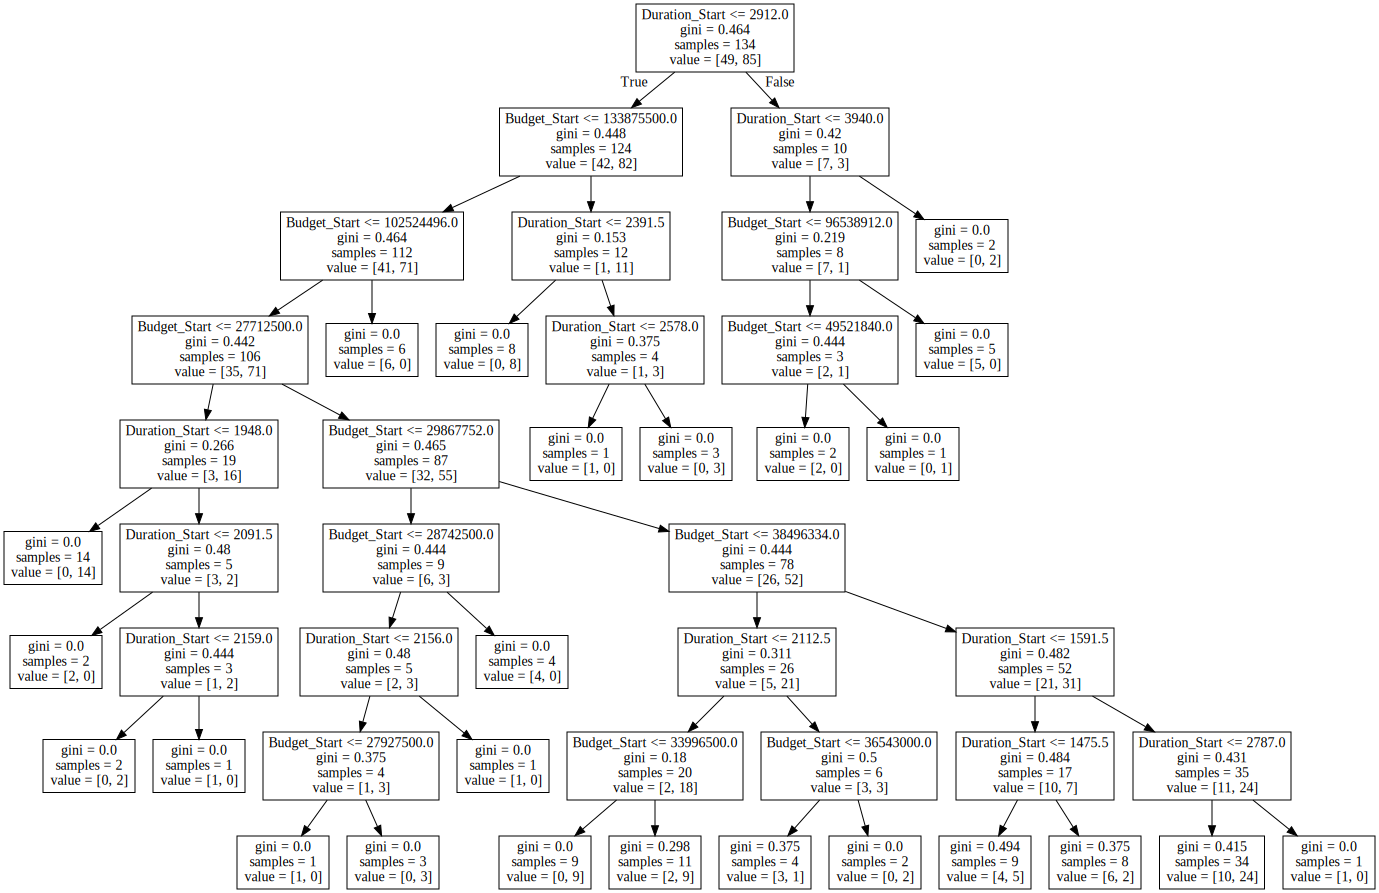

In [31]:
# deepest tree model
idx = results_df.best_depth.idxmax()
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
print(f"Best CV Score of Model Chosen: {m_dict.get('best_cv_score')} // Depth: {m_dict.get('best_depth')}")

xtree = m_dict.best_model

if len(m_dict.dummies_dict) == 0:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=m_dict.attributes)
else:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=list(set(m_dict.attributes) - set(m_dict.dummies_dict.keys())) + m_dict.dummies_dict.get('Category'))
    
gr = graphviz.Source(tree_dot_data)
display(gr)

### Here, we see that there is a pattern in the budget values and some of the project categories. Based on this, we could expect to see some type of grouping in starting duration values in the intervals [1393, 1691, 1870, 1909, 2616, 2929, 3297, 3114] (in days) as these are decision critera at various levels of the tree.  

## Analyze the Best Scoring Model 

Index Chosen: 5
Best CV Score of Model Chosen: 0.75 // Depth: 1


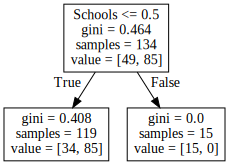

In [32]:
idx = 5 #results_df.best_cv_score.idxmax()
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
print(f"Best CV Score of Model Chosen: {m_dict.get('best_cv_score')} // Depth: {m_dict.get('best_depth')}")

xtree = m_dict.best_model

if len(m_dict.dummies_dict) == 0:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=m_dict.attributes)
else:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=list(set(m_dict.attributes) - set(m_dict.dummies_dict.keys())) + m_dict.dummies_dict.get('Category'))
    
gr = graphviz.Source(tree_dot_data)
display(gr)

### This isn't very exciting.  Projects that are schools or ferries have some predictive value.

Index Chosen: 14
Best CV Score of Model Chosen: 0.75 // Depth: 1


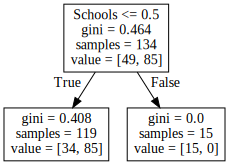

In [33]:
idx = 14
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
print(f"Best CV Score of Model Chosen: {m_dict.get('best_cv_score')} // Depth: {m_dict.get('best_depth')}")

xtree = m_dict.best_model

if len(m_dict.dummies_dict) == 0:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=m_dict.attributes)
else:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=list(set(m_dict.attributes) - set(m_dict.dummies_dict.keys())) + m_dict.dummies_dict.get('Category'))
    
gr = graphviz.Source(tree_dot_data)
display(gr)

### This is interesting.  This model is essential the same as the previous one with the same score except it additionally included the Budget_Start in the attributes.  The resulting decision tree is identical indicating that including the Budget_Start adds no value to the model.

### Analyze the best scoring multi_output model

Index Chosen: 6
Best CV Score of Model Chosen: 0.4 // Depth: 5


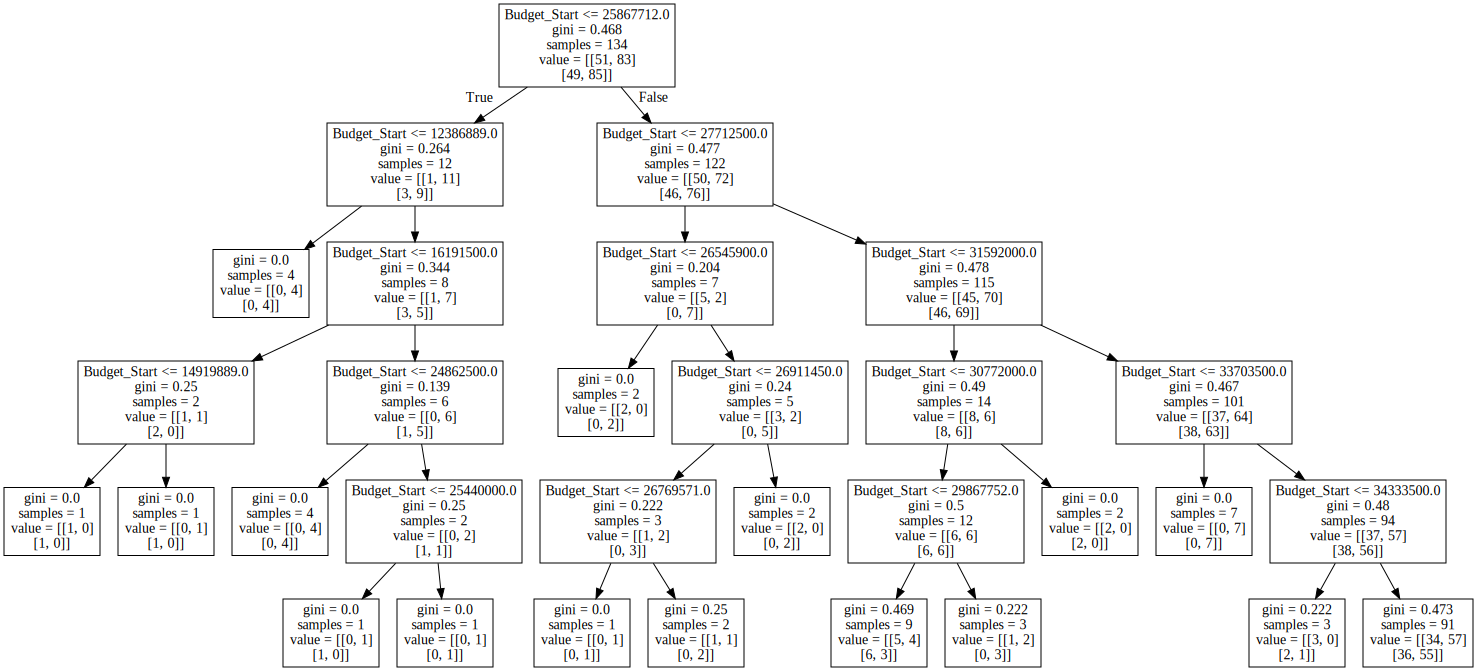

In [34]:

idx = results_df[(results_df.responses.apply(len) == 2)  & (results_df.best_depth != 1)].best_cv_score.idxmax()
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
print(f"Best CV Score of Model Chosen: {m_dict.get('best_cv_score')} // Depth: {m_dict.get('best_depth')}")

xtree = m_dict.best_model

if len(m_dict.dummies_dict) == 0:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=m_dict.attributes)
else:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=list(set(m_dict.attributes) - set(m_dict.dummies_dict.keys())) + m_dict.dummies_dict.get('Category'))
    
gr = graphviz.Source(tree_dot_data)
display(gr)

### This is interesting.  Here, we see that our multioutput model has discovered breaking points in the duration start that have some predictive value.  The intervals [1553, 1870, 1909] have points in common to the previous tree which made classifications based on Duration_Start breaking points.

## Random Forest
Extend the Decision Tree concept by creating a forest of trees where each tree in the forest is a decision tree model with a random starting point.  Using a random forest may uncover some hidden relationships that the decision tree may not find.

In [35]:
n_trees = 150
tree_depth = 6
rf = RandomForestClassifier(   n_estimators=n_trees, 
                               max_depth=tree_depth, 
                               bootstrap=True,
                               oob_score=True,
                               n_jobs=-1, 
                               random_state=0)

In [36]:
# for the forest, we will use all attributes and responses.  Non-essential variables will be 'weeded out' by the forest model.
attributes = [  'Category',
                'Borough',
                'Managing_Agency',
                'Client_Agency',
                'Budget_Start',
                'Duration_Start' ]

dummy_columns = ['Category', 'Borough', 'Managing_Agency', 'Client_Agency']

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

X_tr, X_te, y_tr, y_te, dummies_dict = define_train_and_test(data, dummy_columns, attributes, responses_list[0]) 

In [37]:
rf.fit(X_tr, y_tr)
random_forest_train_score = rf.score(X_tr, y_tr)
random_forest_test_score = rf.score(X_te, y_te)
print("Random Forest performance with {} baggings and tree depth of {}:".format(n_trees, tree_depth))
print("\tRandom Forest Train Score: {}%".format(round(random_forest_train_score*100,2)))
print("\tRandom Forest Test Score: {}%".format(round(random_forest_test_score*100,2)))

Random Forest performance with 150 baggings and tree depth of 6:
	Random Forest Train Score: 70.15%
	Random Forest Test Score: 26.67%


In [38]:
pd.DataFrame({'features':X_tr.columns, 'importance':rf.feature_importances_}).sort_values(by='importance', ascending=False).head()


,features,importance
1,Duration_Start,0.18
0,Budget_Start,0.14
5,Schools,0.08
45,DOE,0.08
40,SCA,0.07


### Using a random forecast, we use a model that creates numerous decision trees starting with randome initial starting points.  We reach a similar score as with our simple manual decision tree which help comfirm that we may have selected the most important features in our Tree model.  When analyzing the most important features of the random forest, we see that Budget_Start and Duration_Start are the most important.  This somewhat aligns with the Tree models we reviewed as these features by themselves drive some of the better performing tree models.  Here, we also see that Schools has importance which also correlates to our best performing tree model.  Using a random forest doesn't add any significant insight or ideas to building a better model.

### Using a Tree Regressor